In [8]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


# Define Jaeger API URL
JAEGER_API_URL = "http://192.168.140.17:16686/api/traces"

# Define parameters for the query
service_name = "compose-post-service" #'home-timeline-service' #"compose-post-service"
lookback = "60m"
limit = 1000

# Function to query Jaeger API
def query_jaeger(service_name, lookback, limit):
    params = {
        "service": service_name,
        "lookback": lookback,
        "limit": limit
    }
    response = requests.get(JAEGER_API_URL, params=params)
    response.raise_for_status()
    return response.json()


# Parse the trace data
def parse_jaeger_data(data):
    traces = data['data']
    trace_list = []
    for trace in traces:
        trace_id = trace['traceID']
        for span in trace['spans']:
            operation = span['operationName']
            start_time = datetime.utcfromtimestamp(span['startTime'] / 1e6)
            duration = span['duration'] / 1e3  # Convert microseconds to milliseconds
            trace_list.append({
                "trace_id": trace_id,
                "operation": operation,
                "start_time": start_time,
                "duration": duration
            })
    return pd.DataFrame(trace_list)


# Fetch trace data from Jaeger
data = query_jaeger(service_name, lookback, limit)

# Parse the data into a DataFrame
df = parse_jaeger_data(data)

# Convert 'start_time' to datetime and 'duration' to numeric
df['start_time'] = pd.to_datetime(df['start_time'])






In [9]:
df.to_csv('TraDE_composePost.csv')
df



,trace_id,operation,start_time,duration
0,0148085ccbf9c6ec,post_storage_mongo_insert_client,2024-07-15 06:56:52.743293,17.295
1,0148085ccbf9c6ec,store_post_server,2024-07-15 06:56:52.743272,17.334
2,0148085ccbf9c6ec,compose_creator_client,2024-07-15 06:56:52.657182,0.562
3,0148085ccbf9c6ec,compose_unique_id_client,2024-07-15 06:56:52.657251,0.697
4,0148085ccbf9c6ec,compose_media_client,2024-07-15 06:56:52.657207,1.011
...,...,...,...,...
32985,14b50dae23ec5382,write_user_timeline_server,2024-07-15 07:33:41.614647,550.481
32986,14b50dae23ec5382,compose_creator_server,2024-07-15 07:33:41.557160,0.008
32987,14b50dae23ec5382,compose_post_client,2024-07-15 07:33:41.556098,635.777
32988,14b50dae23ec5382,/wrk2-api/post/compose,2024-07-15 07:33:41.555954,636.160


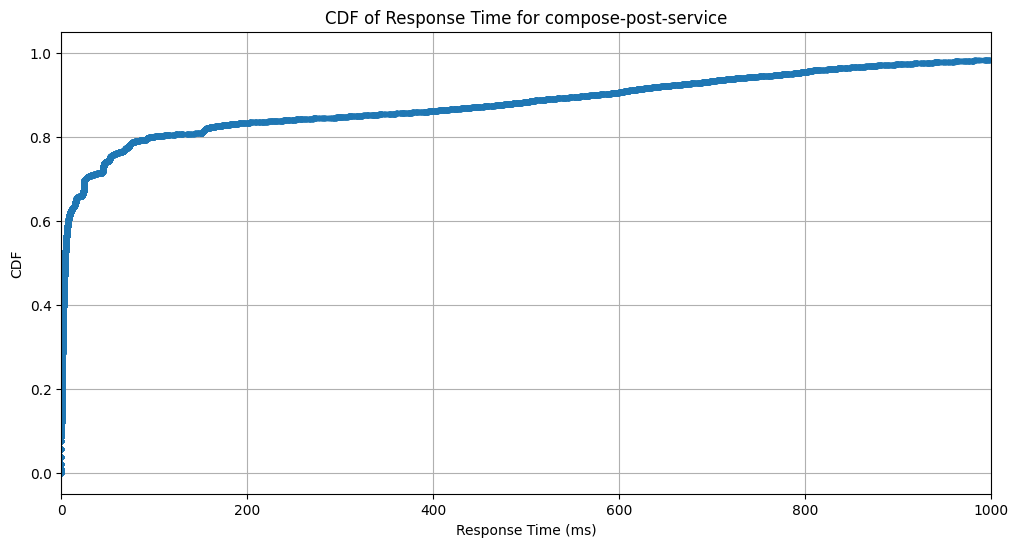

In [11]:

# Check if data is available
if df.empty:
    print("No trace data found.")
else:
    # Convert start_time to datetime for time-based grouping
    
    # Ensure 'duration' column is numeric
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    
    # Drop rows with NaN values in 'duration'
    df = df.dropna(subset=['duration'])

    # Sort the duration values
    sorted_duration = df['duration'].sort_values()

    # Calculate CDF values
    cdf = sorted_duration.rank(method='average', pct=True)

    # Plot the CDF
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_duration, cdf, marker='.', linestyle='none')
    plt.title('CDF of Response Time for compose-post-service')
    plt.xlim(0,1000)
    plt.xlabel('Response Time (ms)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()
